# Analysis of global results

In [1]:
from evaluation_utils import read_global_results, unpivot_baseline_model, unpivot_ssl_model, read_multiple_global_results
from constants import MODE_1_PROCESSED_DIR, MODE_2_3_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, AUXILIARY_ALL,\
    CONTRAST_ALL, HYBRID_ALL, GENERATION_ALL, BASELINES, model_abbreviations, FONT,\
    GENERATION_BASED_CATEGORY, HYBRID_CATEGORY, CONTRAST_BASED, AUXILIARY_CATEGORY, ENCODER_COLORS
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = FONT

SyntaxError: invalid syntax (constants.py, line 7)

In [2]:
# Mode 1 and 2/3 raw
data = read_multiple_global_results(experiments=[
    ('Mode 1', MODE_1_PROCESSED_DIR),
    ('Mode 2/3', MODE_2_3_PROCESSED_DIR)
])

# SSL results
df_ssl = unpivot_ssl_model(df=data, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES)
df_baseline = unpivot_baseline_model(df=data, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES)

1.ndjson
2.ndjson


# 

# Overall model results in each mode

In [3]:
all_models_cols = [TEST_METRIC, 'Graph_ID', 'Experiment']
all_models_df = pd.concat([
    df_ssl.loc[:, all_models_cols + ['SSL_model']].rename(columns={ 'SSL_model': 'Model' }),
    df_baseline.loc[:, all_models_cols + ['Baseline_model']].rename(columns={ 'Baseline_model': 'Model' })
], ignore_index=True)

mode_1_rankings = (
    all_models_df[all_models_df.Experiment == 'Mode 1']
    .groupby('Model')[TEST_METRIC]
    .mean()
    .rank(ascending=False, method='min')
    .reset_index()
    .rename(columns={ TEST_METRIC: 'Mode 1 rank'})
    .astype({ 'Mode 1 rank': int })
)
mode_2_3_rankings = (
    all_models_df[all_models_df.Experiment == 'Mode 2/3']
    .groupby('Model')[TEST_METRIC]
    .mean()
    .rank(ascending=False, method='min')
    .reset_index()
    .rename(columns={ TEST_METRIC: 'Mode 2/3 rank'})
    .astype({ 'Mode 2/3 rank': int })
)
all_models_df = (
    all_models_df
    .pipe(pd.merge, right=mode_1_rankings, on='Model')
    .pipe(pd.merge, right=mode_2_3_rankings, on='Model')
)

all_models_df = all_models_df.astype({
    'Model': 'category',
    'Experiment': 'category'
})

In [4]:
def plot_histogram_old(model_data, model,bins, fig, ax):
    mode1_data = model_data[model_data['Experiment'] == 'Mode 1']

    # # Filter data for Mode 2/3
    mode2_3_data = model_data[model_data['Experiment'] == 'Mode 2/3']

    # Calculate histogram data for Mode 1 and Mode 2/3
    mode1_hist, _ = np.histogram(mode1_data['test_rocauc_ovr'], bins=bins, density=True)
    mode2_3_hist, _ = np.histogram(mode2_3_data['test_rocauc_ovr'], bins=bins, density=True)
    bar_args = { 'width': np.diff(bins), 'align': 'edge', 'alpha': 0.7, 'edgecolor': 'black', 'x': bins[:-1], 'linewidth': 1/2 }

    ax.bar(height=mode1_hist, label='Mode 1', color='darkkhaki', **bar_args)
    ax.bar(height=-mode2_3_hist, label='Mode 2/3', color='teal', **bar_args)

    # Set y-axis label as model name
    ylabel = ax.set_ylabel(model)
    ylabel = ax.set_ylabel(model_abbreviations[model], rotation=0, size=11, ha='right') # Set y-label as model and display horizontally
    ylabel.set_position((-.1, 0.5))  # Move the label to the left


    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    fig.add_subplot(ax)

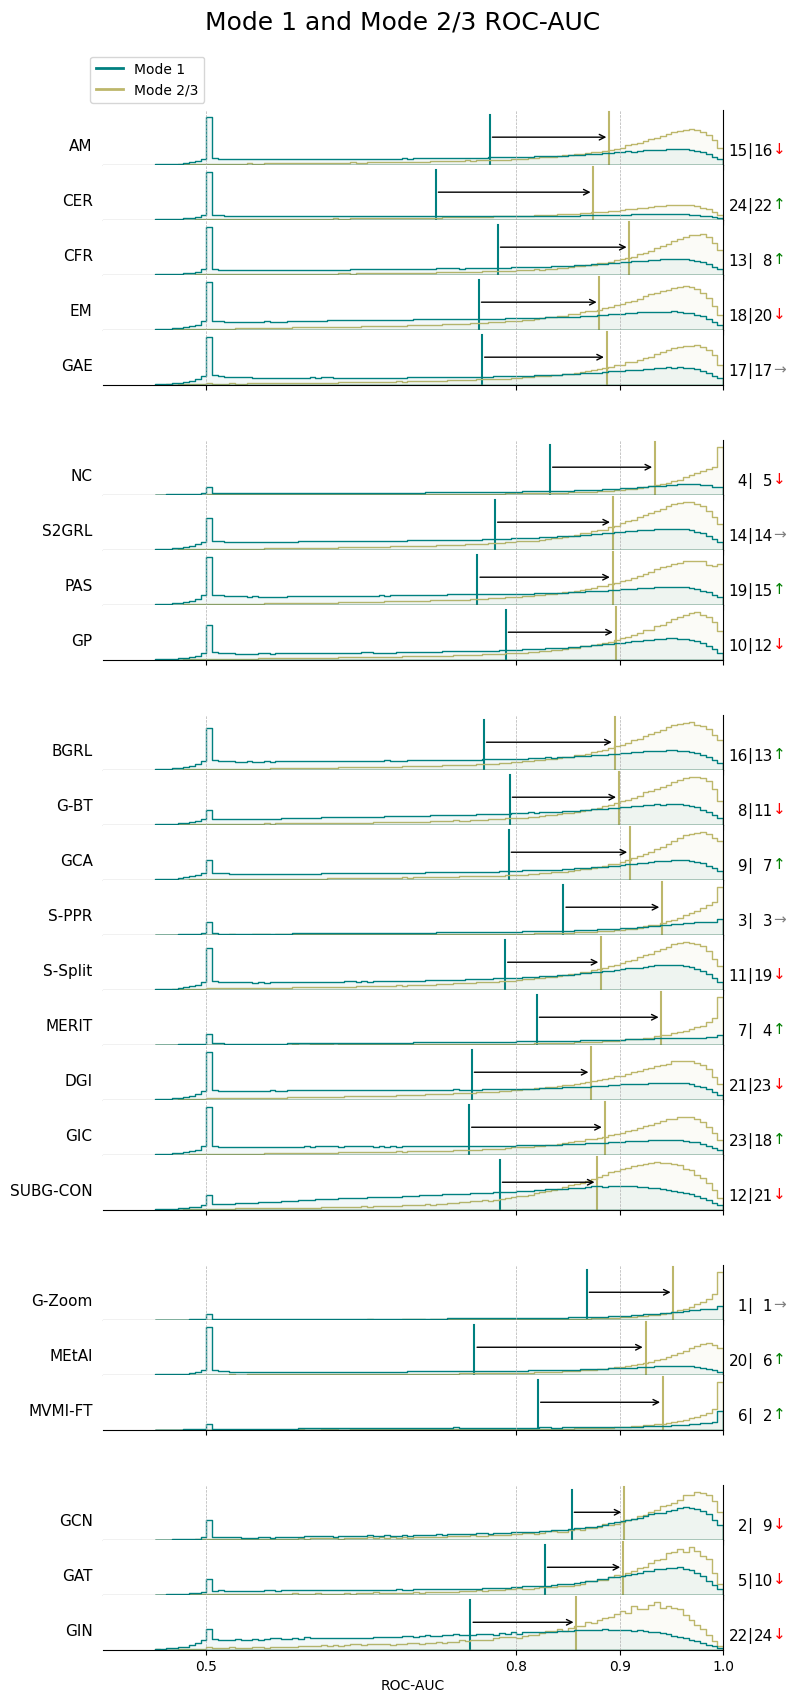

In [194]:
df = all_models_df
color_palette = { 'Mode 1': 'darkkhaki', 'Mode 2/3': 'teal' }

models_with_positions = GENERATION_ALL + AUXILIARY_ALL + CONTRAST_ALL + HYBRID_ALL + BASELINES
bins = np.linspace(0.45, 1.0, num=100)
n_rows = len(models_with_positions) + 4

fig = plt.figure(figsize=(8, 20))
outer = gridspec.GridSpec(nrows=n_rows, ncols=1, hspace=0.002)
color_map = { 'Mode 1': 'teal', 'Mode 2/3': 'darkkhaki' }

legend_elements = [
    Line2D([0], [0], color=color_map['Mode 1'], lw=2, label='Mode 1'),
    Line2D([0], [0], color=color_map['Mode 2/3'], lw=2, label='Mode 2/3')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.91))
fig.suptitle('Mode 1 and Mode 2/3 ROC-AUC', fontsize=18, y=0.93)


cur_idx = -1
axes = []
for models_in_category in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, BASELINES]:
    cur_idx += 1
    for model_idx, model in enumerate(models_in_category):
        ax = plt.Subplot(fig, outer[cur_idx])
        axes += [ax]
        model_data = df[df['Model'] == model]
        sns.histplot(model_data, x=TEST_METRIC, hue='Experiment', 
                     stat='percent', common_norm=False, 
                     element='step', fill=True, 
                     alpha=0.05, bins=bins,
                     palette=color_map,
                     ax=ax)
        
        means = model_data.groupby('Experiment')[TEST_METRIC].mean()
        maxs = model_data.groupby('Experiment')[TEST_METRIC].max()

        # Dashed line for the mean
        # ax.plot([means.loc['Mode 1']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 1'], linestyle='--', zorder=0)
        # ax.plot([means.loc['Mode 2/3']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 2/3'], linestyle='--', zorder=0)

        # Non dashed line for the mean
        ax.plot([means.loc['Mode 1']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 1'], zorder=0)
        ax.plot([means.loc['Mode 2/3']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 2/3'], zorder=0)

        ax.annotate("", xy=(means.loc['Mode 2/3'], ax.get_ylim()[1] / 2), 
            xytext=(means.loc['Mode 1'], ax.get_ylim()[1] / 2),
            arrowprops=dict(facecolor='purple', edgecolor='black', arrowstyle='->'))


        # Bar for the mean
        # ax.bar(means.loc['Mode 1'], ax.get_ylim()[1], color=color_map['Mode 1'], width=0.005, align='center', zorder=0, alpha=0.6)
        # ax.bar(means.loc['Mode 2/3'], ax.get_ylim()[1], color=color_map['Mode 2/3'], width=0.005, align='center', zorder=0, alpha=0.6)

        # Triangle and circle
        # ax.plot(means.loc['Mode 1'], ax.get_ylim()[1] / 2, marker='o', markersize=8, color=color_map['Mode 1'], linestyle='', zorder=3)
        # ax.plot(means.loc['Mode 2/3'], ax.get_ylim()[1] / 2, marker='^', markersize=8, color=color_map['Mode 2/3'], linestyle='', zorder=3)

        # Annotation for the mean
        # ax.annotate(f"Mode 1 Mean: {means.loc['Mode 1']:.3f}", xy=(means.loc['Mode 1'], ax.get_ylim()[1] * 0.9), fontsize=8, color=color_map['Mode 1'], ha='center', va='center')
        # ax.annotate(f"Mode 2/3 Mean: {means.loc['Mode 2/3']:.3f}", xy=(means.loc['Mode 2/3'], ax.get_ylim()[1] * 0.8), fontsize=8, color=color_map['Mode 2/3'], ha='center', va='center')

        # Shaded region
        # ax.axvspan(means.loc['Mode 1'] - 0.01, means.loc['Mode 1'] + 0.01, color=color_map['Mode 1'], alpha=0.3, zorder=1)
        # ax.axvspan(means.loc['Mode 2/3'] - 0.01, means.loc['Mode 2/3'] + 0.01, color=color_map['Mode 2/3'], alpha=0.3, zorder=1)



        ylabel = ax.set_ylabel(model)
        ylabel = ax.set_ylabel(model_abbreviations[model], rotation=0, size=11, ha='right')
        ylabel.set_position((-.1, .2))


    
        # Add rank        
        mode1_rank = model_data.iloc[0]['Mode 1 rank']
        mode23_rank = model_data.iloc[0]['Mode 2/3 rank']        
        mode1_rank_x, rank_y = 1.04, .25
        rank_props = { 'xycoords': 'axes fraction', 'fontsize': 11, 'ha': 'right', 'va': 'center'}

        ax.annotate(f"{mode1_rank:2}", xy=(mode1_rank_x, rank_y), **rank_props)
        ax.annotate('|', xy=(mode1_rank_x + .007, rank_y), **rank_props)
        ax.annotate(f"{mode23_rank:2}", xy=(mode1_rank_x + .04, rank_y), **rank_props)


        if mode1_rank > mode23_rank:
            arrow_direction = u'\u2191'
            arrow_color = 'green'
        elif mode23_rank > mode1_rank :
            arrow_direction = u'\u2193'
            arrow_color = 'red'
        else:
            arrow_direction = u'\u2192'
            arrow_color = 'gray'

        ax.annotate(arrow_direction, xy=(1.04, .2), xycoords="axes fraction", xytext=(1.08, 0.20),
                    textcoords="axes fraction", fontsize=11, color=arrow_color)


        ax.get_legend().remove()
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(False)
        ax.xaxis.grid(True, linestyle='--', linewidth=0.5)
        ax.set_xlim([0.4, 1.0])
        axes[-1].set_xticks([0.5, 0.8, 0.9, 1])
        cur_idx += 1

        if cur_idx < n_rows:
            ax.set_xlabel('')
            ax.set_xticklabels([])

        fig.add_subplot(ax)

axes[-1].set_xlabel('ROC-AUC')
axes[0].annotate('', xy=(0, -0.1), xycoords='axes fraction', xytext=(1, -0.1), 
            arrowprops=dict(arrowstyle="<->", color='b'))
fig.canvas.draw()

# Encoder results

In [6]:
grp = df_ssl.groupby(['SSL_category', 'Training_scheme', 'Encoder', 'Experiment'])
encoder_mean = grp[TEST_METRIC].mean().reset_index()
encoder_std = grp[TEST_METRIC].std().reset_index()

## Auxiliary-property based

In [7]:
encoder_mean[encoder_mean.SSL_category == AUXILIARY_CATEGORY]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
0,Auxiliary-property based,JL,GAT,Mode 1,0.793850
1,Auxiliary-property based,JL,GAT,Mode 2/3,0.917287
2,Auxiliary-property based,JL,GCN,Mode 1,0.810560
3,Auxiliary-property based,JL,GCN,Mode 2/3,0.910199
4,Auxiliary-property based,JL,GIN,Mode 1,0.738649
5,Auxiliary-property based,JL,GIN,Mode 2/3,0.880746
6,Auxiliary-property based,PF,GAT,Mode 1,0.825968
7,Auxiliary-property based,PF,GAT,Mode 2/3,0.923939
8,Auxiliary-property based,PF,GCN,Mode 1,0.852304
9,Auxiliary-property based,PF,GCN,Mode 2/3,0.914073


In [72]:
create_encoder_latex_table(encoder_mean[encoder_mean.SSL_category == AUXILIARY_CATEGORY], encoder_std[encoder_std.SSL_category == AUXILIARY_CATEGORY])

Mode 1
$0.85\pm0.14$ & $0.83\pm0.14$ & $0.76\pm0.14$ & $0.81\pm0.14$ & $0.81\pm0.13$ & $0.71\pm0.15$ & $0.81\pm0.16$ & $0.79\pm0.16$ & $0.74\pm0.16$ 
Mode 2/3
$0.91\pm0.09$ & $0.92\pm0.08$ & $0.88\pm0.11$ & $0.91\pm0.10$ & $0.91\pm0.10$ & $0.88\pm0.11$ & $0.91\pm0.09$ & $0.92\pm0.08$ & $0.88\pm0.10$ 


## Generation based

In [13]:
encoder_mean[encoder_mean.SSL_category == GENERATION_BASED_CATEGORY]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
36,Generation based,JL,GAT,Mode 1,0.749987
37,Generation based,JL,GAT,Mode 2/3,0.907446
38,Generation based,JL,GCN,Mode 1,0.763364
39,Generation based,JL,GCN,Mode 2/3,0.897827
40,Generation based,JL,GIN,Mode 1,0.686522
41,Generation based,JL,GIN,Mode 2/3,0.863221
42,Generation based,PF,GAT,Mode 1,0.822596
43,Generation based,PF,GAT,Mode 2/3,0.913516
44,Generation based,PF,GCN,Mode 1,0.846950
45,Generation based,PF,GCN,Mode 2/3,0.906145


## Contrast based

In [14]:
encoder_mean[encoder_mean.SSL_category == CONTRAST_BASED]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
18,Contrast based,JL,GAT,Mode 1,0.783036
19,Contrast based,JL,GAT,Mode 2/3,0.909829
20,Contrast based,JL,GCN,Mode 1,0.809396
21,Contrast based,JL,GCN,Mode 2/3,0.910629
22,Contrast based,JL,GIN,Mode 1,0.704184
23,Contrast based,JL,GIN,Mode 2/3,0.865129
24,Contrast based,PF,GAT,Mode 1,0.823247
25,Contrast based,PF,GAT,Mode 2/3,0.914419
26,Contrast based,PF,GCN,Mode 1,0.848946
27,Contrast based,PF,GCN,Mode 2/3,0.915207


## Hybrid

In [15]:
encoder_mean[encoder_mean.SSL_category == HYBRID_CATEGORY]

,SSL_category,Training_scheme,Encoder,Experiment,test_rocauc_ovr
54,Hybrid,JL,GAT,Mode 1,0.776496
55,Hybrid,JL,GAT,Mode 2/3,0.943562
56,Hybrid,JL,GCN,Mode 1,0.798194
57,Hybrid,JL,GCN,Mode 2/3,0.935838
58,Hybrid,JL,GIN,Mode 1,0.728490
59,Hybrid,JL,GIN,Mode 2/3,0.926338
60,Hybrid,PF,GAT,Mode 1,0.862841
61,Hybrid,PF,GAT,Mode 2/3,0.943636
62,Hybrid,PF,GCN,Mode 1,0.885531
63,Hybrid,PF,GCN,Mode 2/3,0.942678


# Increase in performance

,test_rocauc_ovr,pretext_weight,SSL_model,Encoder,Training_scheme,Graph_ID
0,0.949540,None,AttributeMask,GCN,PF,0
1,0.984346,None,AttributeMask,GCN,PF,1
2,0.775972,None,AttributeMask,GCN,PF,4
3,0.763285,None,AttributeMask,GCN,PF,5
4,0.978847,None,AttributeMask,GCN,PF,6
...,...,...,...,...,...,...
16748248,0.953252,1,MVMI_FT,GIN,JL,99995
16748249,0.727067,50,MVMI_FT,GIN,JL,99996
16748250,0.657303,50,MVMI_FT,GIN,JL,99997
16748251,0.863095,10,MVMI_FT,GIN,JL,99998


# Mode 2/3 Results

In [8]:
df_ssl_mode_2_3 = df_ssl[df_ssl.Experiment == 'Mode 2/3']

## Auxiliary property-based

In [9]:
df_aux = df_ssl_mode_2_3[df_ssl_mode_2_3.SSL_category == AUXILIARY_CATEGORY]

In [134]:
dat = df_ssl[df_ssl.SSL_category == CONTRAST_BASED].sample(10_000)

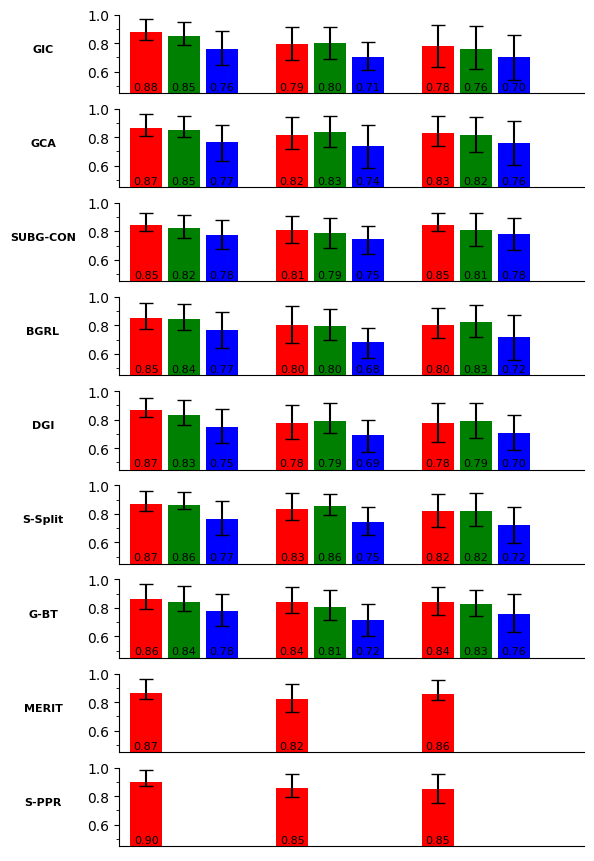

In [184]:
positions = {}
idx = 0
for scheme in TRAINING_SCHEMES:
    for encoder in ENCODERS:
        positions[f'{scheme}-{encoder}'] = idx
        idx += 0.35
    idx += 0.3



def adjust_axis(model_i, model, training_i, training_scheme, ax, inner_grid, fig):
    if training_i == 0:
            ax.set_ylabel(model_abbreviations[model], fontsize=8, fontweight='bold', rotation=0, labelpad=32)
    ax.set_xticks([])

    ax.set_yticks([0.6, 0.8, 1.0], minor=False)
    ax.set_yticks([0.5, 0.7, 0.9], minor=True)
    ax.set_yticklabels({0.6: '0.6', 0.8: '0.8', 1.0: '1.0'}, minor=False)



    # ax.set_yticklabels(['', '', 0.6, '', 0.8, '', 1.0])
    ax.set_ylim([0.45, 1.0])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)



def plot_bars(df):
    MODELS = df.SSL_model.unique()
    fig = plt.figure(figsize=(6, len(MODELS) * 1.2))
    outer = gridspec.GridSpec(ncols=1, nrows=len(MODELS), wspace=0.8, hspace=0.2)

    # Model
    for model_i, model in enumerate(MODELS):
        model_df = df[df.SSL_model == model]
        ax = plt.Subplot(fig, outer[model_i])
        # Training scheme
        for training_i, training_scheme in enumerate(TRAINING_SCHEMES):
            model_training_df = model_df[model_df.Training_scheme == training_scheme]
            adjust_axis(model_i, model, training_i, training_scheme, ax, None, fig)
            
            ################################ Error plot ################################
            for encoder in ENCODERS:
                model_training_encoder_df = model_training_df[model_training_df.Encoder == encoder]
                if len(model_training_encoder_df) == 0:
                    continue
                mean = model_training_encoder_df[TEST_METRIC].mean()
                # std = model_training_encoder_df[TEST_METRIC].std()
                ci = np.abs(mean - model_training_encoder_df[TEST_METRIC].quantile(q=(1/4, 3/4)).to_numpy())
                pos = positions[f'{training_scheme}-{encoder}']
                bar_width = 0.3
                ax.bar(x=pos, height=mean, color=ENCODER_COLORS[encoder], yerr=np.array([ci]).T, capsize=5, align='edge', 
                        label=f'{mean:.2f}', width=bar_width)
                ax.text(pos + bar_width / 2, 0.46, f'{mean:.2f}', fontsize=8, va='bottom', ha='center', color='black')

            fig.add_subplot(ax)

    for ax in fig.get_axes():
        ax.set_xlim((min(positions.values()) - 0.1, max(positions.values()) + 0.8))

plot_bars(dat)

/tmp/ipykernel_6299/3662725487.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ENCODERS)
/tmp/ipykernel_6299/3662725487.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ENCODERS)
/tmp/ipykernel_6299/3662725487.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ENCODERS)


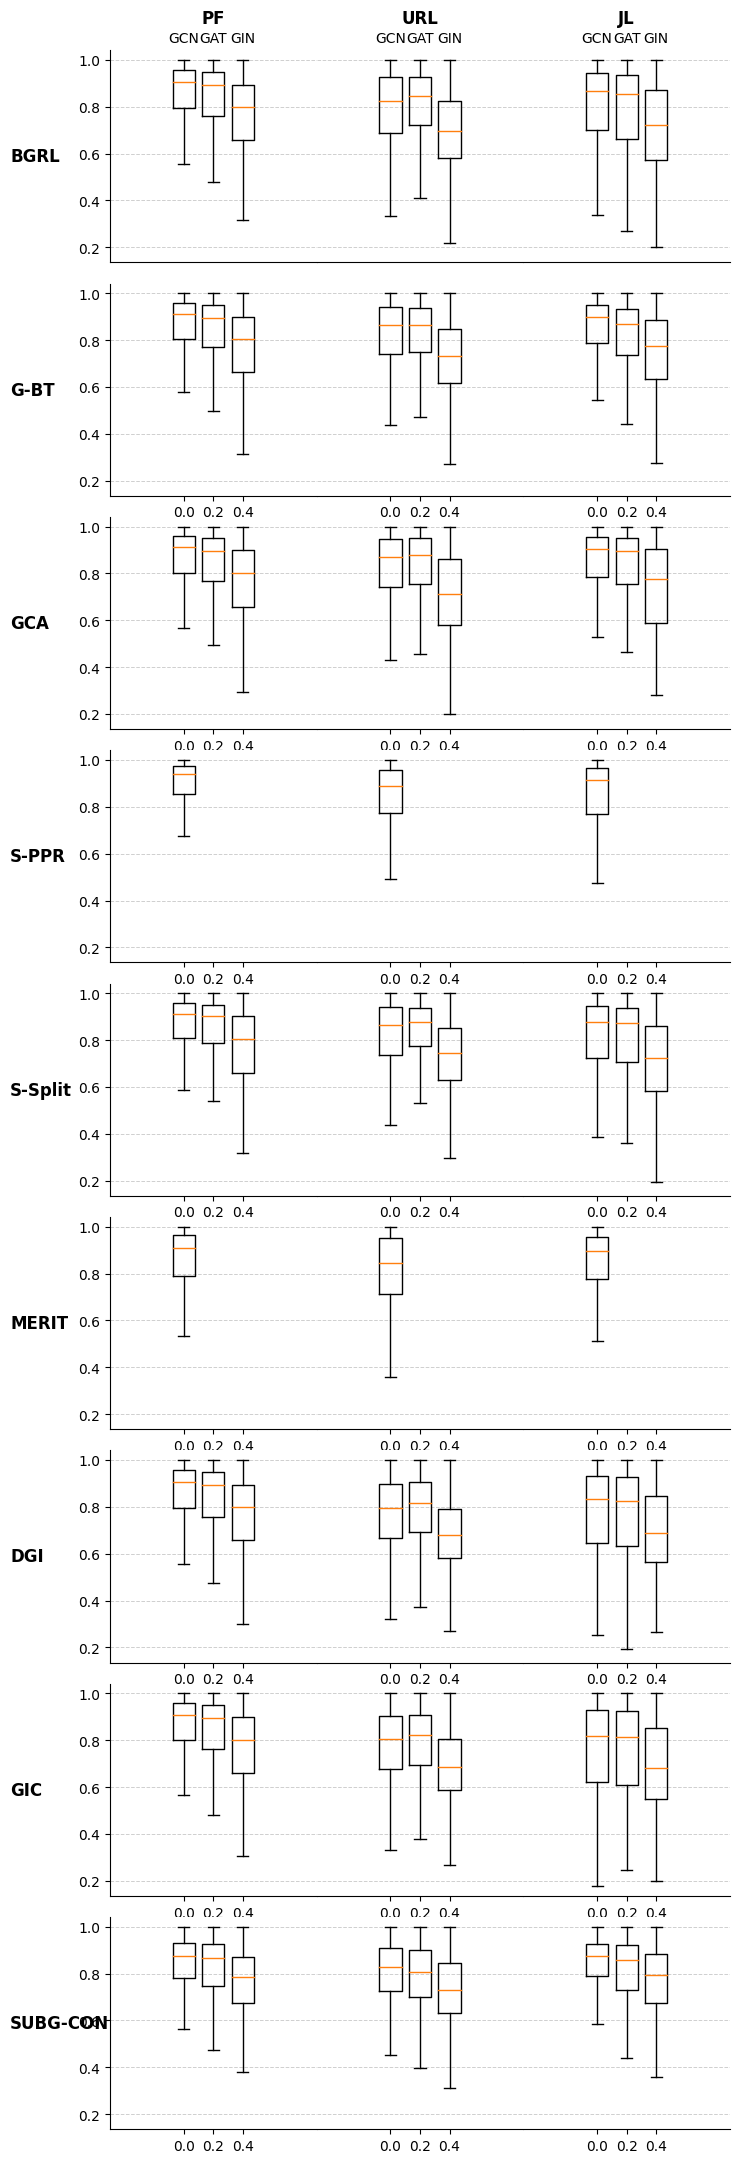

In [86]:
def plot_bars(df):
    encoder_positions = { 'GCN': 0, 'GAT': 0.2, 'GIN': 0.4 }
    MODELS = df.SSL_model.unique()
    fig = plt.figure(figsize=(8, len(MODELS) * 3))
    outer = gridspec.GridSpec(nrows=len(MODELS), ncols=1, wspace=0, hspace=0.1)

    # Model
    for model_i, model in enumerate(MODELS):
        model_df = df[df.SSL_model == model]
        inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[model_i, 0], wspace=0, hspace=0)
        
        # Training scheme
        for training_i, training_scheme in enumerate(TRAINING_SCHEMES):
            model_training_df = model_df[model_df.Training_scheme == training_scheme]
            ax = plt.Subplot(fig, inner[training_i])
            ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)
            
            # Add a subtitle for the model
            if model_i == 0:
                ax.set_title(training_scheme, fontsize=12, fontweight='bold')
                ax.set_xticklabels(ENCODERS)
                ax.xaxis.tick_top()
                ax.tick_params(axis='x', length=0)
            else:
                ax.set_xticks([])
                ax.set_xticklabels([])
            

            if not (training_i == 0):
                ax.tick_params(axis='y', length=0)
                ax.set_yticklabels([])
                # ax.set_yticks([])
                ax.spines['left'].set_visible(False)
            else:
                ypos = inner[training_i].get_position(fig).y0 + 0.5 * inner[training_i].get_position(fig).height
                fig.text(0.00, ypos, model_abbreviations[model], fontweight='bold', fontsize=12, ha='left', va='center')
                
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['right'].set_visible(False)


            data_points, positions, quantiles, medians = [], [], [], []
            # Encoder
            for encoder_i, encoder in enumerate(ENCODERS):
                model_training_encoder_df = model_training_df[model_training_df.Encoder == encoder]
   
                data_points += [model_training_encoder_df[TEST_METRIC]]
                positions += [encoder_positions[encoder]]


                

            ax.boxplot(data_points, notch=False, vert=True, showfliers=False, positions=positions)


            fig.add_subplot(ax)



    # Find the minimum and maximum x values across all subplots
    min_y, max_y = float('inf'), float('-inf')
    for ax in fig.get_axes():
        min_y = min(min_y, ax.get_ylim()[0])
        max_y = max(max_y, ax.get_ylim()[1])

    # Set the same x-axis limits across all subplots
    for ax in fig.get_axes():
        ax.set_ylim(min_y, max_y)
plot_bars(df_ssl[df_ssl.SSL_category == CONTRAST_BASED])

/tmp/ipykernel_6299/535036848.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group'] = df['Encoder'] + ' - ' + df['Training_scheme']


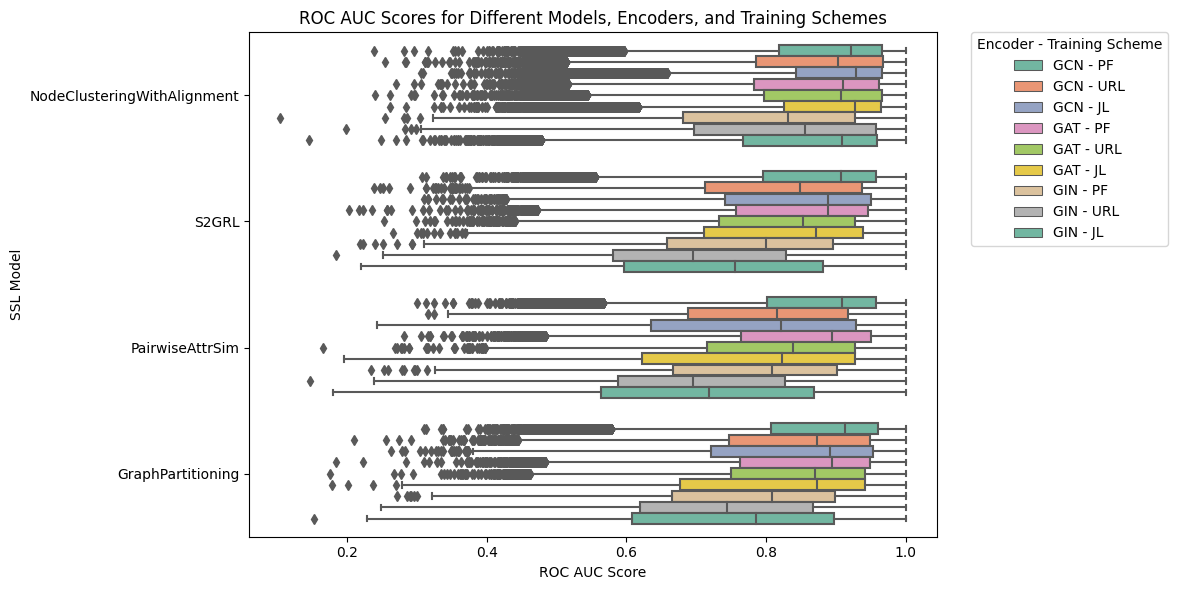

In [14]:
# Assuming your dataframe is called 'df'
df = df_aux

# Combine 'Encoder' and 'Training_scheme' into a new column 'Group'
df['Group'] = df['Encoder'] + ' - ' + df['Training_scheme']

# Create a horizontal box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    y="SSL_model",
    x="test_rocauc_ovr",
    hue="Group",
    dodge=True,  # This will separate the box plots based on the 'Group'
    orient="h",  # This makes the box plots horizontal
    palette="Set2"
)

# Customize the legend
plt.legend(title="Encoder - Training Scheme", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Set the y-axis labels
plt.ylabel("SSL Model")

# Set the x-axis label
plt.xlabel("ROC AUC Score")

# Set the title
plt.title("ROC AUC Scores for Different Models, Encoders, and Training Schemes")

# Show the plot
plt.tight_layout()
plt.show()
